In [1]:
from tools import *
plt.ion()
from matplotlib import patches, lines, text
d = load_data()
%config InlineBackend.figure_format = 'retina'

In [2]:
def find_mag_ang(x, z):
    mag = np.sqrt(x**2 + z**2)
    
    if x > 0 and z > 0:
        ang = np.arctan(z/x) * (180/np.pi)
    elif x < 0 and z > 0:
        ang = 180 + np.arctan(z/x) * (180/np.pi)
    elif x < 0 and z < 0:
        ang = 180 + np.arctan(z/x) * (180/np.pi)
    elif x > 0 and z < 0:
        ang = 2 * 180 + np.arctan(z/x) * (180/np.pi)
    
    return(mag, ang)

In [55]:
trial = d['P11']['trials']['t5']

print trial['name']
x = trial['index8x'][-1] - trial['objectx'][-1]
z = trial['index8z'][-1] - trial['objectz'][-1] - 0.02
mag, ang = find_mag_ang(x, z)

print 'Magnitude = {}'.format(mag)
print 'Angle     = {}'.format(ang)

Roman_Occlusion_Cue_LeftToRight0004
Magnitude = 0.0514767136674
Angle     = 169.538356472


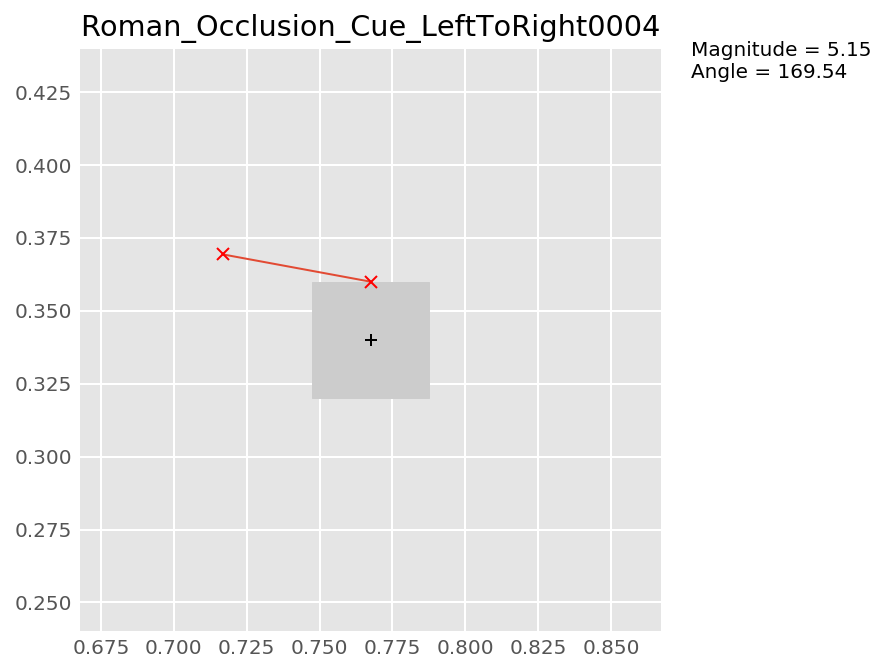

In [64]:
style.use('ggplot')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)

ind_x = trial['index8x'][-1]
ind_z = trial['index8z'][-1]
obj_x = trial['objectx'][-1]
obj_z = trial['objectz'][-1]

xl, xr = obj_x - 0.1, obj_x + 0.1
yb, yt = obj_z - 0.1, obj_z + 0.1
asp = (xr - xl) / (yt - yb)

ax1.add_patch(patches.Rectangle( (obj_x - 0.02, obj_z - 0.02), 0.04, 0.04, color = [0.8, 0.8, 0.8]) )
ax1.add_line(lines.Line2D([ind_x, obj_x], [ind_z, obj_z + 0.02], linewidth = 1))
ax1.plot(ind_x, ind_z, 'rx')
ax1.plot(obj_x, obj_z + 0.02, 'rx')
ax1.plot(obj_x, obj_z,'k+')

ax1.set_xlim(xl, xr)
ax1.set_ylim(yb, yt)
ax1.set_aspect(asp)
ax1.set_title(trial['name'])
ax1.text(xr + 0.01, yt - 0.01, 'Magnitude = {}\nAngle = {}'.format(np.round(mag, 4)*100, np.round(ang, 2)))